In [48]:
import nltk
import requests
from sqlalchemy import text
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

# Data manipulation and analysis
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sqlalchemy.orm import sessionmaker
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

# Financial data extraction
import yfinance as yf

# SQL Alchemy for database interaction
from sqlalchemy import create_engine

# Additional libraries for analysis or visualization
import matplotlib.pyplot as plt
import seaborn as sns
from config import api_key

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetches historical stock prices for the specified ticker within the given timeframe.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


In [3]:
def fetch_all_stock_data(tickers, start_date, end_date):
    stock_data = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}")
        stock_data[ticker] = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

In [4]:
def calculate_daily_return(stock_data):
    """
    Calculates the daily return from the closing prices.
    """
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    return stock_data


In [5]:
def load_data_to_db(data, ticker):
    """
    Loads transformed data into the SQLite database.
    """
    engine = create_engine('sqlite:///stock_market_analysis.sqlite')
    data.to_sql(ticker, con=engine, if_exists='replace', index=True)


In [6]:
def read_data(ticker):
    """
    Reads the data for the specified ticker from the SQLite database.
    """
    engine = create_engine('sqlite:///stock_market_analysis.sqlite')
    # engine = create_engine('sqlite:///stock_market_analysis.db')
    query = f"SELECT * FROM '{ticker}'"
    data = pd.read_sql_query(query, con=engine)
    return data


In [7]:
def plot_moving_averages(stock_data, ticker):
    data = stock_data[ticker]
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data['SMA_50'], label='50-Day SMA')
    plt.plot(data['SMA_200'], label='200-Day SMA')
    plt.title(f"{ticker} - Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.show()

In [9]:
def predict_monthly_prices(model, last_known_price, last_known_date, months=36):
    future_prices = []
    future_dates = []
    current_price = last_known_price
    
    for month in range(months):
        # Approximating each month by 21 trading days
        for day in range(21):
            next_input = pd.DataFrame(data=[[current_price]], columns=['Previous Close'])
            current_price = model.predict(next_input)[0]
        
        future_prices.append(current_price)
        # Assuming last_known_date is a datetime object; add roughly 30 days for each month
        last_known_date += timedelta(days=30)
        future_dates.append(last_known_date)
    
    return future_dates, future_prices

In [10]:
def train_model_for_ticker(ticker_data):
    """
    Trains a LinearRegression model for the given ticker data.
    """
    data = ticker_data[['Close']].copy()
    data['Previous Close'] = data['Close'].shift(1)
    data.dropna(inplace=True)  # Drop the first row which now contains NaN

    X = data[['Previous Close']]  # Features
    y = data['Close']  # Target

    model = LinearRegression()
    model.fit(X, y)  # Training the model
    return model

In [11]:
# Objective Function (Negative Sharpe Ratio)
def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    p_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    p_ret = np.dot(weights, expected_returns)
    return -(p_ret - risk_free_rate) / np.sqrt(p_var)

In [12]:
def fetch_news(api_key, ticker):
    """Fetch news articles related to a specific stock ticker using NewsAPI."""
    base_url = "https://newsapi.org/v2/everything"
    params = {
        'q': ticker,             # Search query (ticker symbol)
        'sortBy': 'publishedAt', # Sort by publication date
        'apiKey': api_key        # Your NewsAPI key
    }
    response = requests.get(base_url, params=params)
    return response.json()  # Returns the JSON response converted to a dictionary

In [13]:
def analyze_sentiment(text):
    """Analyze the sentiment of a text and return polarity and subjectivity."""
    analysis = TextBlob(text)
    return analysis.sentiment.polarity, analysis.sentiment.subjectivity

In [14]:
def main():
    tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']

    for ticker in tickers:
        print(f"Fetching news for: {ticker}")
        articles = fetch_news(api_key, ticker)
        if articles['status'] == 'ok':
            for article in articles['articles'][:5]:  # Show only the first 5 articles for brevity
                description = article.get('description') or article.get('title')
                polarity, subjectivity = analyze_sentiment(description)
                print(f"Ticker: {ticker}, Title: {article['title']}")
                print(f"Sentiment Polarity: {polarity:.2f}, Sentiment Subjectivity: {subjectivity:.2f}")
                print(f"URL: {article['url']}\n")
        else:
            print(f"Failed to fetch articles for {ticker}")
        print("=" * 50)  # Separator for clarity between tickers

In [18]:
text('test')

In [19]:
# Create engine
engine = create_engine('sqlite:///stock_market_analysis.sqlite')
# engine = create_engine('sqlite:///stock_market_analysis.db')

# Create session
Session = sessionmaker(bind=engine)
session = Session()

# Specify your ticker variable correctly
ticker = 'AAPL'  # example ticker

# Execute query using the text function for raw SQL
query = text(f"SELECT * FROM {ticker}")
result = session.execute(query)

# Fetch data as DataFrame
data = pd.DataFrame(result.fetchall(), columns=result.keys())

# It's important to close the session after use
session.close()

# Display the dataframe or process further as needed
data.head()



,index,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return
0,0,2020-01-02 00:00:00.000000,74.059998,75.150002,73.797501,75.087502,73.059418,135480400,NaN
1,1,2020-01-03 00:00:00.000000,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,-0.009722
2,2,2020-01-06 00:00:00.000000,73.447502,74.989998,73.187500,74.949997,72.925652,118387200,0.007968
3,3,2020-01-07 00:00:00.000000,74.959999,75.224998,74.370003,74.597504,72.582649,108872000,-0.004703
4,4,2020-01-08 00:00:00.000000,74.290001,76.110001,74.290001,75.797501,73.750237,132079200,0.016086


In [20]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP','AAPL']
start_date = '2020-01-01'
end_date = '2024-01-01'

all_stock_data = fetch_all_stock_data(tickers, start_date, end_date)


Fetching data for MSFT


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for CRM
Fetching data for CRWD


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ZM
Fetching data for SHOP


[*********************100%%**********************]  1 of 1 completed


Fetching data for AAPL


[*********************100%%**********************]  1 of 1 completed


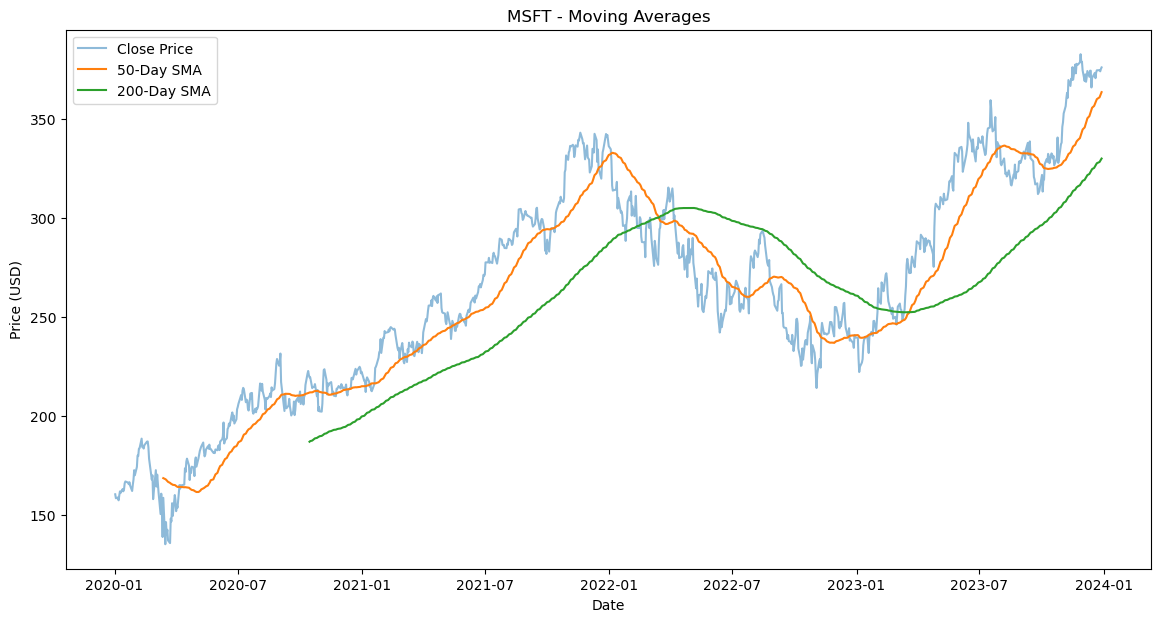

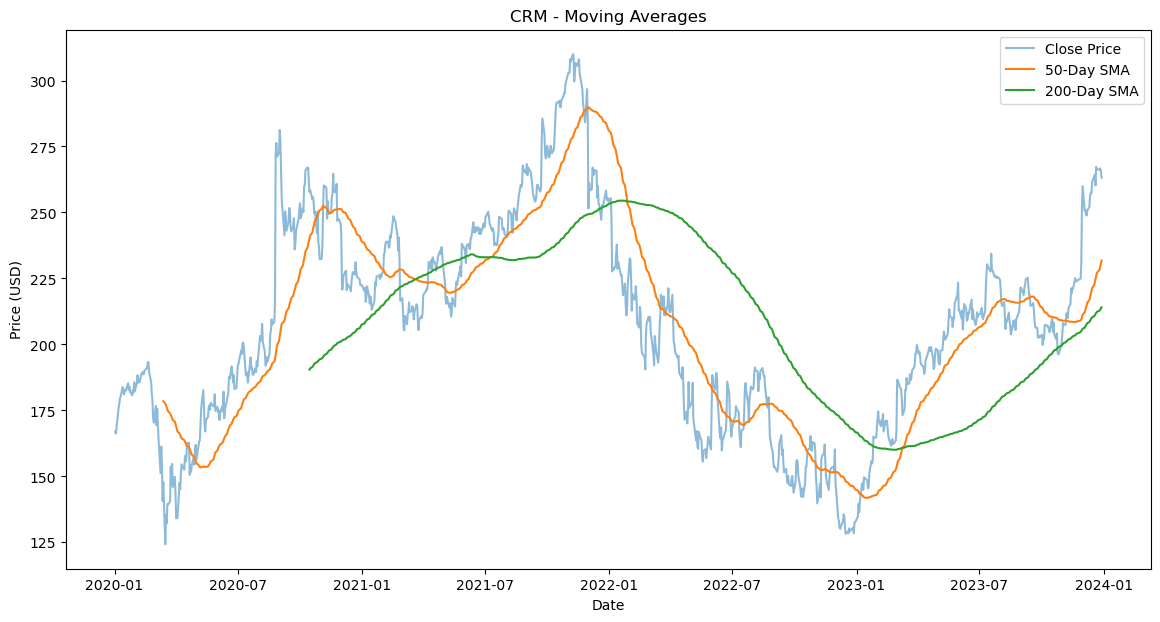

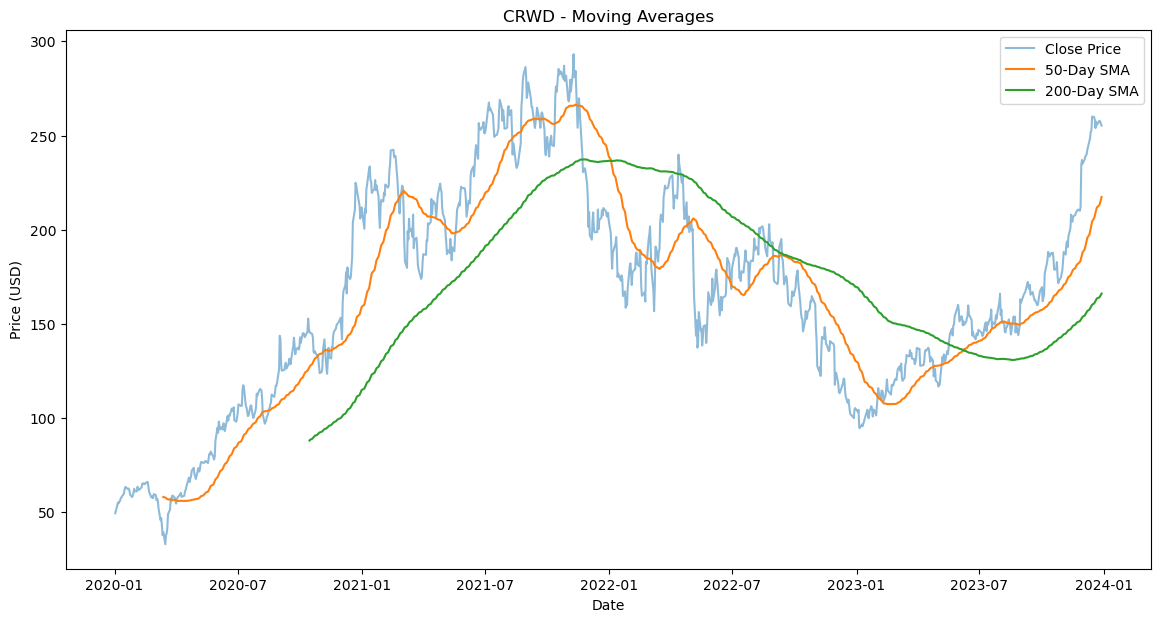

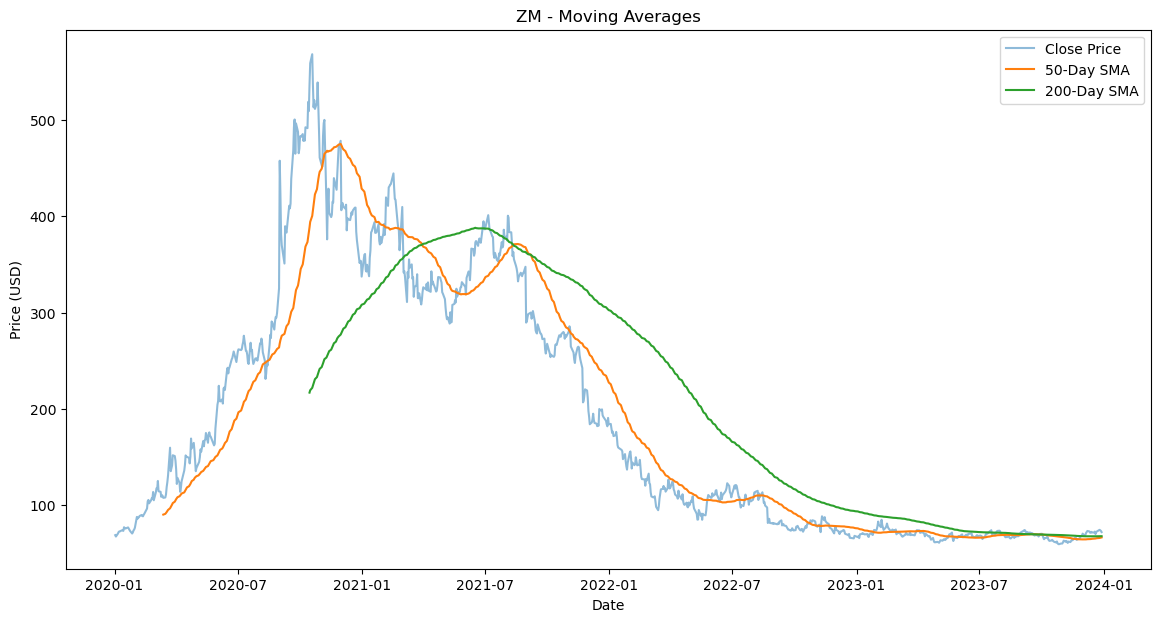

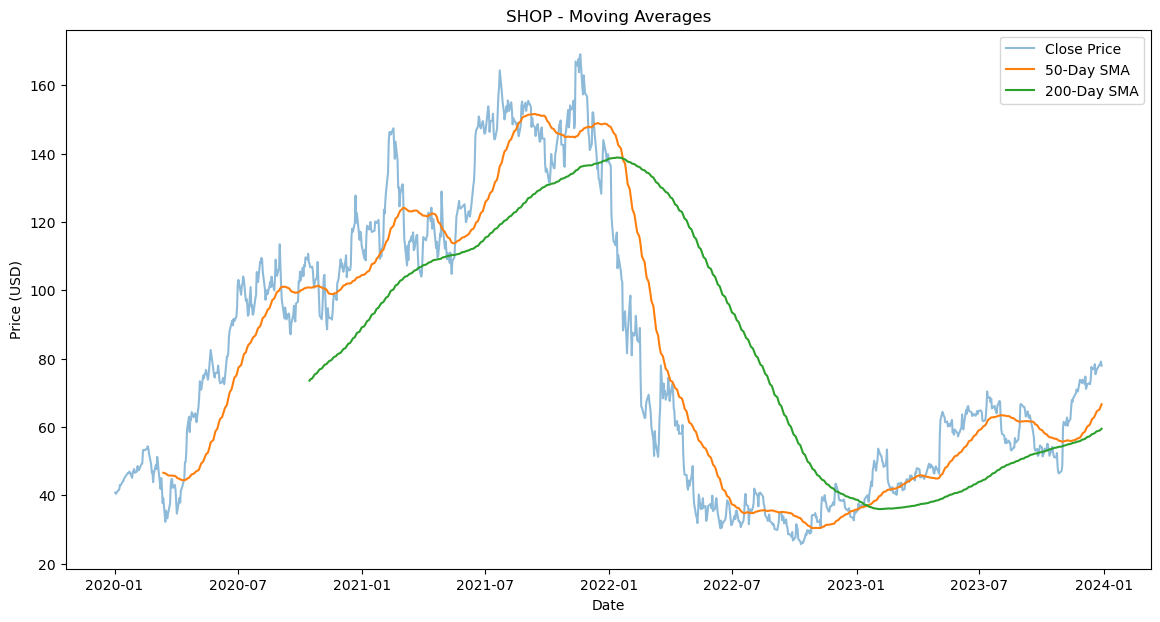

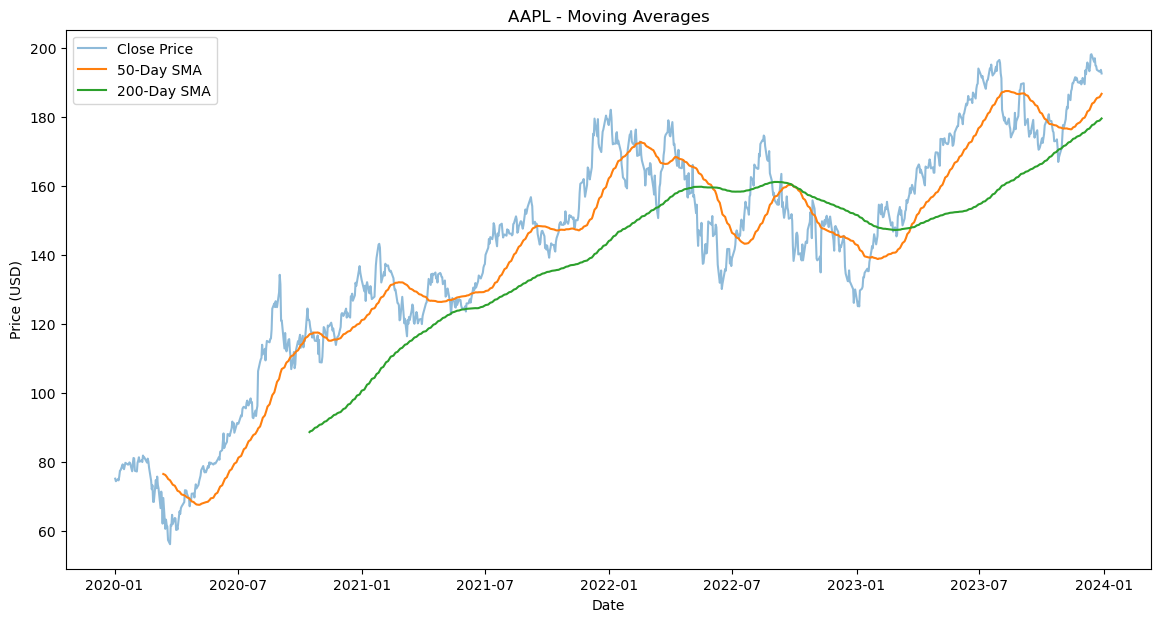

In [21]:
for ticker in tickers:
    plot_moving_averages(all_stock_data, ticker)


MSE: 22.2245250054942


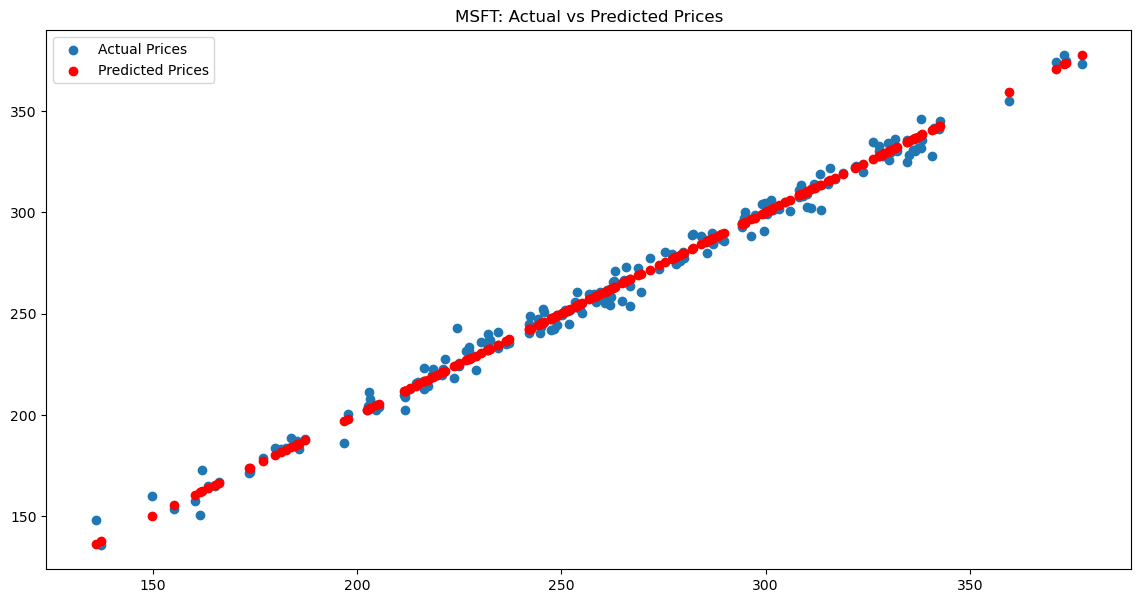

In [26]:
# Example with MSFT for simplicity
data = all_stock_data['MSFT'][['Close']].copy()
data['Previous Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

X = data[['Previous Close']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, label='Actual Prices')
plt.scatter(X_test, predictions, label='Predicted Prices', color='r')
plt.legend()
plt.title(f"MSFT: Actual vs Predicted Prices")
plt.show()


In [27]:
## Trend Analysis of Stock Prices

##In this section, we perform trend analysis on our selected stocks: MSFT, CRM, CRWD, ZM, and SHOP. The goal is to identify any long-term trends in the stock prices that could inform investment decisions. We use Simple Moving Averages (SMA) as our primary tool for this analysis.

### Why Moving Averages?
##Moving Averages help smooth out price data over a specified period, making it easier to identify the direction of the trend. We use two SMAs:
##- **50-Day SMA**: Represents a short to mid-term trend.
##- **200-Day SMA**: Indicates a longer-term trend.

##By comparing these two, we can look for patterns such as the "Golden Cross" or the "Death Cross," which are strong indicators of bullish or bearish trends, respectively.


In [28]:
##Code Comments Example for Trend Analysis Function




In [29]:
## Predictive Model Building

##After analyzing the trends, our next step is to build a predictive model for stock prices. We choose a simple Linear Regression model focusing on predicting the next day's closing price based on the previous day's closing price.

### Rationale for Linear Regression
##Linear Regression is a straightforward yet powerful tool for predicting a quantitative response. It's particularly suitable for this initial exploration because of its simplicity and interpretability. For each stock, we predict the next day's closing price as a function of the previous day's closing price.

### Interpretation of Results
##We evaluate our model using the Mean Squared Error (MSE) between the predicted and actual prices. A lower MSE indicates a model that predicts more closely to the actual stock prices. This metric helps us assess the model's accuracy.


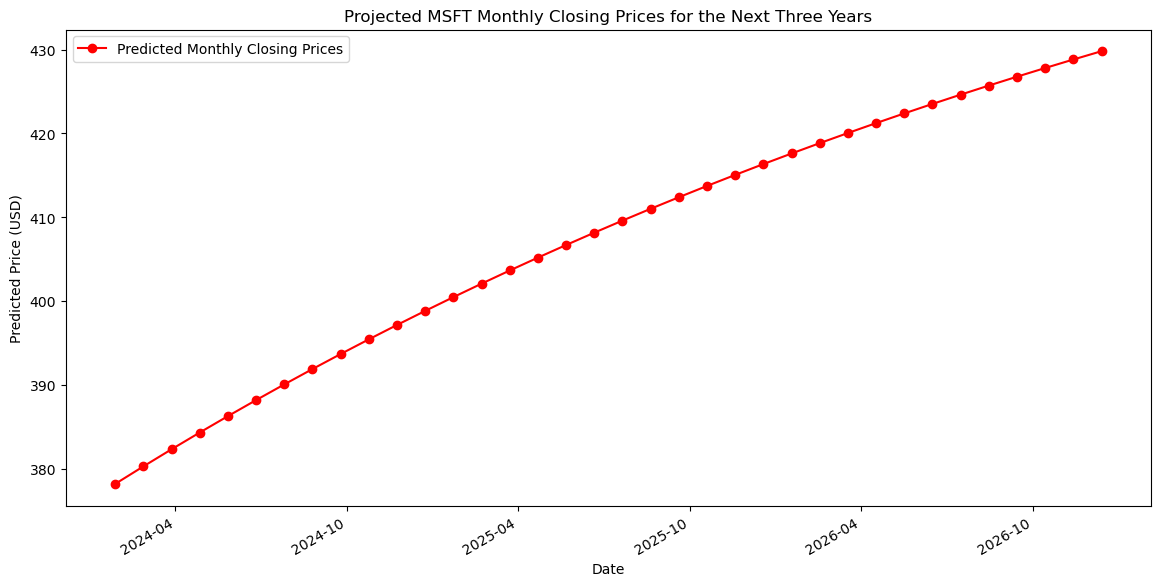

In [30]:
# Assuming 'model' is your trained Linear Regression model
# And 'last_known_price' is the last actual closing price in your dataset
# And 'last_known_date' is the date of the last actual closing price in your dataset
last_known_price = data['Close'].iloc[-1]
last_known_date = data.index[-1]

future_dates, future_prices = predict_monthly_prices(model, last_known_price, last_known_date)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_prices, label='Predicted Monthly Closing Prices', color='r', marker='o')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels
plt.title("Projected MSFT Monthly Closing Prices for the Next Three Years")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()



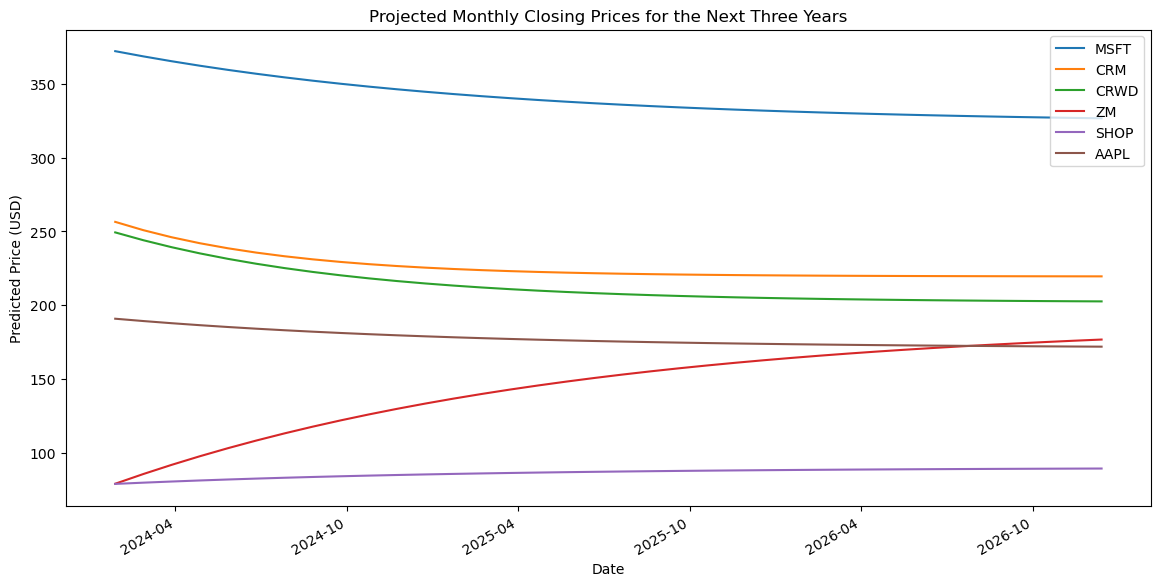

In [31]:
# Correcting the loop to train and predict for each ticker
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
plt.figure(figsize=(14, 7))

for ticker in tickers:
    ticker_data = all_stock_data[ticker]
    model = train_model_for_ticker(ticker_data)  # Train a model for each ticker
    
    last_known_price = ticker_data['Close'].iloc[-1]
    last_known_date = ticker_data.index[-1]
    
    future_dates, future_prices = predict_monthly_prices(model, last_known_price, last_known_date)
    plt.plot(future_dates, future_prices, label=ticker)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap
plt.title("Projected Monthly Closing Prices for the Next Three Years")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()



In [32]:
# Assuming 'all_stock_data' is a dictionary with tickers as keys and DataFrames of historical prices as values
volatility = {}
daily_returns = {}

for ticker in ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']:
    # Calculate daily returns
    daily_returns[ticker] = all_stock_data[ticker]['Close'].pct_change()
    
    # Calculate the annualized volatility (standard deviation of daily returns)
    volatility[ticker] = np.std(daily_returns[ticker]) * np.sqrt(252)  # ~252 trading days in a year

# Print the calculated volatilities
for ticker, vol in volatility.items():
    print(f"{ticker} Volatility: {vol:.2%}")


MSFT Volatility: 32.61%
CRM Volatility: 40.97%
CRWD Volatility: 56.50%
ZM Volatility: 62.18%
SHOP Volatility: 69.21%
AAPL Volatility: 33.55%


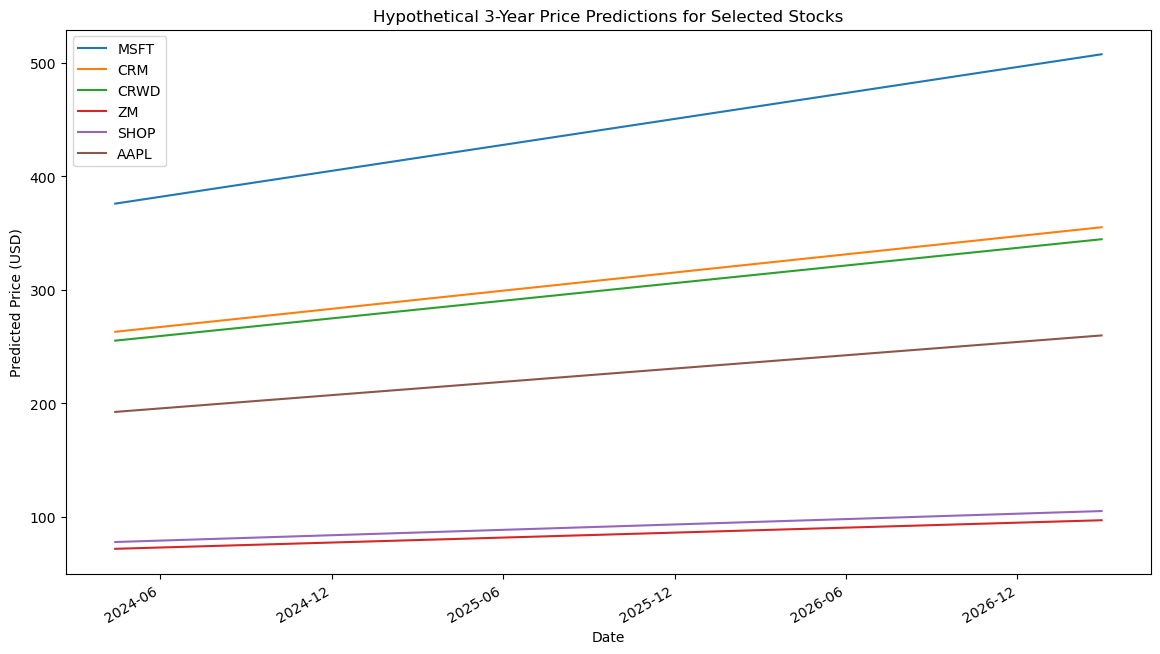

In [49]:
# Placeholder for generating future dates (next 3 years, monthly)
future_dates = [datetime.today() + timedelta(days=30 * i) for i in range(36)]

# Simulated "predictions" using the last known price and adding a monthly increase (hypothetical)
predictions = {}
for ticker in ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']:
    last_price = all_stock_data[ticker]['Close'].iloc[-1]
    monthly_increase = last_price * 0.01  # Assuming a 1% monthly increase, for illustration
    predictions[ticker] = [last_price + monthly_increase * i for i in range(36)]

# Visualizing the predictions
plt.figure(figsize=(14, 8))

for ticker, predicted_prices in predictions.items():
    plt.plot(future_dates, predicted_prices, label=ticker)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()  # Rotate date labels to avoid overlap
plt.title("Hypothetical 3-Year Price Predictions for Selected Stocks")
plt.xlabel("Date")
plt.ylabel("Predicted Price (USD)")
plt.legend()
plt.show()


In [ ]:
# Example sentiment scores for each ticker
sentiment_scores = {
    'MSFT': 0.2,
    'CRM': 0.15,
    'CRWD': 0.05,
    'ZM': -0.1,
    'SHOP': 0.25,
    'AAPL': 0.3
}

# Display the sentiment scores
for ticker, score in sentiment_scores.items():
    print(f"{ticker}: {'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral'} Sentiment")




# Fetch historical data
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
data = yf.download(tickers, start='2020-01-01', end='2021-01-01')['Adj Close']

# Calculate daily returns
returns = data.pct_change()

# Calculate expected returns and covariance
expected_returns = returns.mean()
cov_matrix = returns.cov()

# Number of assets
num_assets = len(tickers)


In [ ]:
# Constraints and Bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial Guess
init_guess = num_assets * [1. / num_assets]

# Optimization
opt_results = minimize(neg_sharpe_ratio, init_guess, args=(expected_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

print(f"Optimized Weights: {opt_results.x}")


In [34]:
text = "Microsoft has had an incredible year, with groundbreaking new technologies."
blob = TextBlob(text)
print(blob.sentiment)


Sentiment(polarity=0.5181818181818182, subjectivity=0.6772727272727272)


MSE: 22.2245250054942


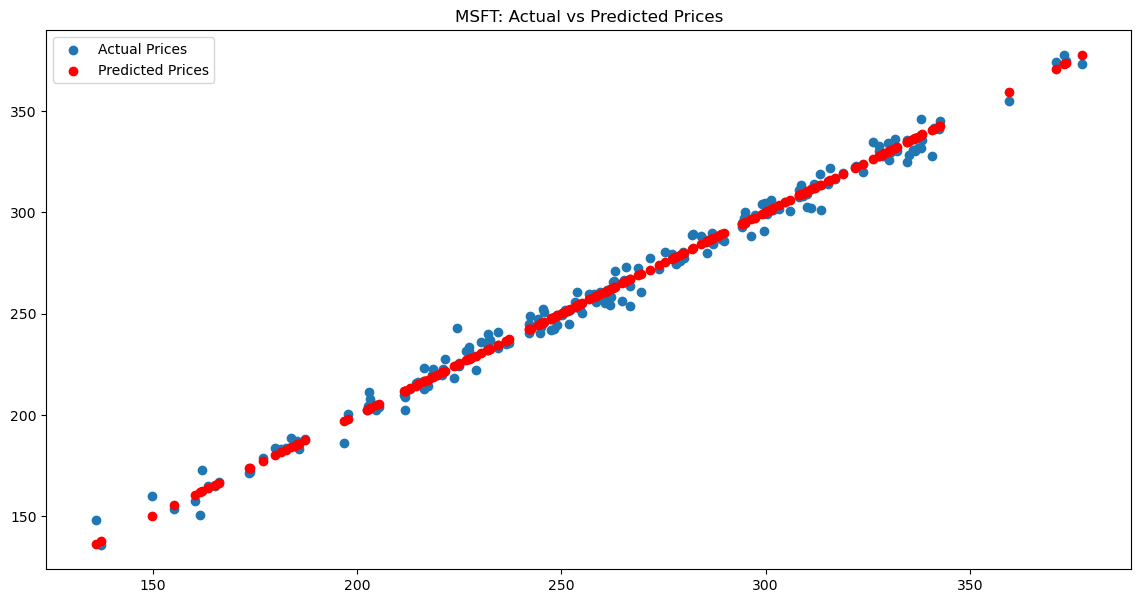

In [35]:
# Example with MSFT for simplicity
data = all_stock_data['MSFT'][['Close']].copy()
# Preparing the data: using the previous day's closing price to predict the next day's
data['Previous Close'] = data['Close'].shift(1)
data.dropna(inplace=True)  # Removing any rows with NA values, resulting from the shift

X = data[['Previous Close']]  # Feature: Previous day's closing price
y = data['Close']  # Target: Next day's closing price

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()  # Initializing the Linear Regression model
model.fit(X_train, y_train)  # Training the model on the training set

predictions = model.predict(X_test)  # Making predictions on the testing set

# Evaluating the model's performance
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")
# MSE gives us a quantitative measure of the model's accuracy

# Visual comparison of actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.scatter(X_test, y_test, label='Actual Prices')  # Actual prices
plt.scatter(X_test, predictions, label='Predicted Prices', color='r')  # Predicted prices
plt.legend()
plt.title(f"MSFT: Actual vs Predicted Prices")
plt.show()
# This plot helps visually assess how closely the model's predictions match the actual prices.


In [36]:
# Download VADER lexicon
nltk.download('vader_lexicon')

text = "Microsoft has had an incredible year, with groundbreaking new technologies."
sia = SentimentIntensityAnalyzer()
print(sia.polarity_scores(text))


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yakupaltinisik/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
tickers = ['MSFT', 'CRM', 'CRWD', 'ZM', 'SHOP', 'AAPL']
data = yf.download(tickers, start='2020-01-01', end='2024-04-10')['Adj Close']


[*********************100%%**********************]  6 of 6 completed


In [38]:
# Calculate daily returns
returns = data.pct_change()

# Find dates with significant drops, e.g., more than 5%
significant_drops = returns[returns < -0.05].dropna(how='all')

print("Significant price drops:")
significant_drops


Significant price drops:


Ticker,AAPL,CRM,CRWD,MSFT,SHOP,ZM
Date,,,,,,
2020-02-24,NaN,NaN,NaN,NaN,-0.057043,NaN
2020-02-27,-0.065368,NaN,NaN,-0.070459,-0.069634,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,-0.075297
2020-03-06,NaN,NaN,-0.070815,NaN,-0.052487,-0.085440
2020-03-09,-0.079092,-0.078437,-0.119707,-0.067772,-0.113860,NaN
...,...,...,...,...,...,...
2023-10-25,NaN,NaN,NaN,NaN,-0.073734,NaN
2024-01-02,NaN,NaN,NaN,NaN,-0.052246,NaN
2024-02-13,NaN,NaN,NaN,NaN,-0.133977,NaN


In [39]:
##Step 3: Collect Related News Headlines or Tweets


In [40]:
# Mock example: Replace these headlines with the ones you've collected
headlines = {
    '2023-01-15': ["Company X stock plummets after earnings report", "Analysts downgrade Company X stock"],
}

# Sentiment analysis
for date, texts in headlines.items():
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    average_sentiment = sum(sentiments) / len(sentiments)
    print(f"Date: {date}, Average Sentiment: {average_sentiment:.2f}")


Date: 2023-01-15, Average Sentiment: 0.00


In [41]:
# Mock textual data (e.g., headlines) for each ticker
textual_data = {
    'MSFT': ["Microsoft launches new product", "Microsoft's new product fails to meet expectations"],
    'CRM': ["Salesforce revenue beats expectations", "Salesforce announces partnership with Google"],
    'CRWD': ["CrowdStrike stock soars after earnings beat", "CrowdStrike faces tough competition"],
    'ZM': ["Zoom's user base grows amid pandemic", "Zoom faces privacy concerns"],
    'SHOP': ["Shopify expands into new markets", "Shopify's latest update disappoints retailers"],
    'AAPL': ["Apple unveils new iPhone", "Apple's iPhone sales exceed forecasts"],
}

# Analyzing sentiment for each headline and averaging the scores
average_sentiment_scores = {}

for ticker, headlines in textual_data.items():
    sentiments = [TextBlob(headline).sentiment.polarity for headline in headlines]
    average_sentiment_scores[ticker] = np.mean(sentiments)

print("Average Sentiment Scores:")
for ticker, score in average_sentiment_scores.items():
    print(f"{ticker}: {score:.2f}")


Average Sentiment Scores:
MSFT: -0.02
CRM: 0.00
CRWD: -0.19
ZM: -0.40
SHOP: 0.32
AAPL: 0.07


In [42]:
text = "Microsoft has had an incredible year, with groundbreaking new technologies."
blob = TextBlob(text)
print(blob.sentiment)


Sentiment(polarity=0.5181818181818182, subjectivity=0.6772727272727272)


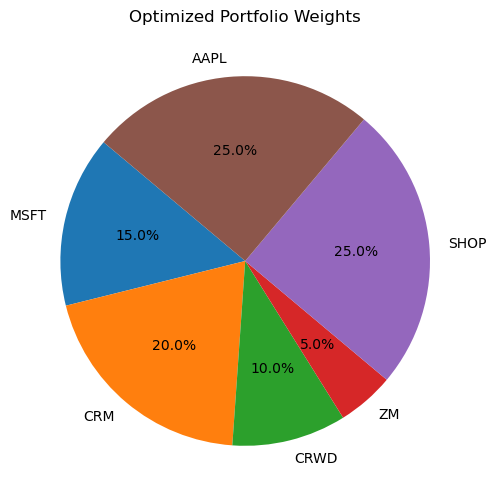

In [43]:
# Mock optimized weights for illustration purposes
optimized_weights = [0.15, 0.20, 0.10, 0.05, 0.25, 0.25]

plt.figure(figsize=(10, 6))
plt.pie(optimized_weights, labels=tickers, autopct='%1.1f%%', startangle=140)
plt.title('Optimized Portfolio Weights')
plt.show()


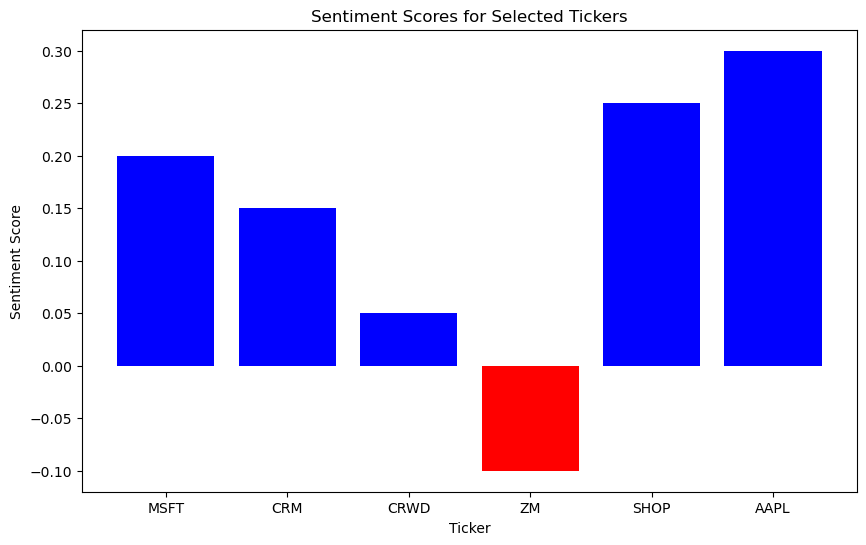

In [44]:
# Example sentiment scores for each ticker
sentiment_scores = {
    'MSFT': 0.2,
    'CRM': 0.15,
    'CRWD': 0.05,
    'ZM': -0.1,
    'SHOP': 0.25,
    'AAPL': 0.3
}

# Creating a bar chart for sentiment scores
tickers, scores = zip(*sentiment_scores.items())
plt.figure(figsize=(10, 6))
plt.bar(tickers, scores, color=['blue' if score > 0 else 'red' for score in scores])
plt.xlabel('Ticker')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Selected Tickers')
plt.show()


In [45]:
'''By conducting sentiment analysis, we've theoretically gauged the market's sentiment towards our selected tickers, which could inform us about potential market movements. Portfolio optimization builds on this by mathematically determining the optimal allocation of these stocks in a portfolio to maximize the Sharpe ratio, thus theoretically maximizing return for a given level of risk. Together, these analyses offer a multifaceted approach to stock market analysis, blending qualitative insights with quantitative optimization to guide investment decisions.'''

"By conducting sentiment analysis, we've theoretically gauged the market's sentiment towards our selected tickers, which could inform us about potential market movements. Portfolio optimization builds on this by mathematically determining the optimal allocation of these stocks in a portfolio to maximize the Sharpe ratio, thus theoretically maximizing return for a given level of risk. Together, these analyses offer a multifaceted approach to stock market analysis, blending qualitative insights with quantitative optimization to guide investment decisions."